In [1]:
# I am trying to implement Vision Transformer from scratch to get basic ideas of how it is built and gain conceptual understanding.
# Nothing here is my original work, it is all referenced to get handson in the details.

<p align="center">
  <img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2021-01-26_at_9.43.31_PM_uI4jjMq.png" alt>
  <em><p align="center">Vision Transformer</p></em>
</p>

The input image is decomposed into 16x16 flatten patches (the image is not in scale). Then they are embedded using a normal fully connected layer, a special cls token is added in front of them and the positional encoding is summed. The resulting tensor is passed first into a standard Transformer and then to a classification head.

**Architecture:**
- Data
- Patches Embeddings
    - CLS Token
    - Position Embedding
- Transformer
    - Attention
    - Residuals
    - MLP
    - TransformerEncoder
- Head
- ViT

In [3]:
pip install einops

In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

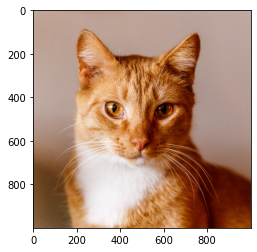

In [5]:
img = Image.open('./cat.jpg')

fig = plt.figure()
plt.imshow(img)

In [6]:
# resize to imagenet size # 1 image * 3 channels (RGB) *224*224
transform = Compose([Resize((224, 224)), ToTensor()])
x = transform(img)
x = x.unsqueeze(0) # add batch dim
x.shape

torch.Size([1, 3, 224, 224])

<p align="center">
  <img src="https://miro.medium.com/max/1400/0*Pf-AqtRsdOlWrP7n" alt>
  <em><p align="center">Step1: Break down image into patches</p></em>
</p>

The standard transformer takes 1D input images, so 2D images must be transformed. so an image x of shape R(H*W*C) will be transformed to R(N*P^2 *C) where P(Patch) is P*P is resolution of each patch and N is H*W/P^2 the number of patches.

In [7]:
patch_size = 16 # 16 pixels
patches = rearrange(x, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size) # Using einops to make patches

<p align="center">
  <img src="https://miro.medium.com/max/1400/0*kEANaRaJkCPu685t" alt>
  <em><p align="center">Step2: Transfer to linear projection</p></em>
</p>



In [8]:
# This code takes in a patch and generates an embedding
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # break-down the image in s1 x s2 patches and flat them
            Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )
                
    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)
        return x

In [9]:
PatchEmbedding()(x).shape # 1 is image 196 is no of patches (224*224/16*16 = 196), emb size = 16*16*3 = 768

torch.Size([1, 196, 768])

Authors are using a Conv2d layer instead of a Linear one for performance gain. This is obtained by using a kernel_size and stride equal to the `patch_size`. Intuitively, the convolution operation is applied to each patch individually. So, we have to first apply the conv layer and then flat the resulting images.

In [10]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
                
    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)
        return x
    
PatchEmbedding()(x).shape

torch.Size([1, 196, 768])

Next step is to add the cls token and the position embedding. The cls token is just a number placed in front of each sequence (of projected patches). cls_token is a torch Parameter randomly initialized, in the forward the method it is copied b (batch) times and prepended before the projected patches using torch.cat



In [11]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768):
        self.patch_size = patch_size
        super().__init__()
        self.proj = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.proj(x)
        print(x.shape)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        print(cls_tokens.shape)
        print(cls_tokens)
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        return x
    
PatchEmbedding()(x).shape

torch.Size([1, 196, 768])
torch.Size([1, 1, 768])
tensor([[[ 1.2461e+00, -4.5185e-01, -9.9254e-01, -1.2221e-01, -5.8836e-01,
          -1.9576e+00,  1.3111e+00, -1.2554e-01, -1.4233e+00, -5.8260e-01,
          -2.4189e-01, -1.0026e-01,  1.2883e+00, -6.3740e-01, -1.9017e-02,
          -2.4415e-01,  1.1831e+00,  8.9219e-01,  6.0419e-02, -1.0926e+00,
          -8.9998e-02,  6.8926e-02, -2.4064e-01,  1.6734e-01, -1.2755e+00,
          -2.1273e+00, -5.7397e-01, -2.4600e+00, -1.6367e-01,  2.6703e-01,
          -2.3611e-01, -8.6003e-01,  6.3038e-01,  1.1121e+00, -3.9455e-01,
          -4.1623e-01,  9.1292e-02, -1.8349e-01,  8.7471e-01,  1.6778e-02,
           1.2932e+00, -1.2636e+00, -1.4619e-01, -1.3377e+00,  5.9505e-01,
          -3.3780e-01, -7.8106e-01,  2.1508e+00, -1.7261e+00, -2.0318e-01,
          -1.4889e+00, -3.8541e-01, -1.5805e-01,  8.5703e-01, -7.1066e-01,
           8.3206e-02,  1.5468e+00, -3.3163e-01, -3.3723e-01, -1.1250e+00,
          -1.7470e-01,  1.0000e+00, -2.3798e-01, -

torch.Size([1, 197, 768])

## POSITIONAL EMBEDDING
So far, the model has no idea about the original position of the patches. We need to pass this spatial information. This can be done in different ways, in ViT we let the model learn it. The position embedding is just a tensor of shape N_PATCHES + 1 (token), EMBED_SIZE that is added to the projected patches.


<p align="center">
  <img src="https://miro.medium.com/max/1400/0*F_igiisSnY9tUeAK" alt>
  <em><p align="center">Step3: Patch + Position Embedding</p></em>
</p>



In [12]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768, img_size: int = 224):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size)) # class token
        # This is a learnable parameter.
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size)) # Position embedding (197,768)
        print(self.positions)
        print(self.positions.shape)

        
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        print("**")
        print(x.shape)
        # add position embedding
        x += self.positions
        print(x.shape)
        print(x)
        return x
    
PatchEmbedding()(x).shape

Parameter containing:
tensor([[-0.2250, -0.0549,  0.3451,  ..., -1.4539,  1.3920,  0.2913],
        [ 0.4869, -0.7963,  0.6088,  ...,  1.8684, -1.3398,  0.7684],
        [-0.3075, -0.2936,  0.2337,  ..., -1.2223, -0.0958, -1.5931],
        ...,
        [ 2.4420, -0.9071,  0.1895,  ...,  0.6659, -2.6907, -0.7767],
        [ 0.0753,  0.7036, -0.1707,  ...,  2.0012, -0.4573,  0.4593],
        [ 0.7992,  1.5599, -0.2523,  ..., -2.1444, -0.2201,  1.4566]],
       requires_grad=True)
torch.Size([197, 768])
**
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
tensor([[[-0.8186,  0.7926,  1.4369,  ..., -0.5693,  1.5292, -0.2278],
         [ 0.7422, -0.3277,  0.6420,  ...,  2.0973, -1.3909,  0.5383],
         [-0.0555,  0.1690,  0.2593,  ..., -0.9919, -0.1506, -1.8245],
         ...,
         [ 2.5019, -0.7862,  0.2450,  ...,  0.6966, -2.7220, -0.8303],
         [ 0.1260,  0.8138, -0.1561,  ...,  2.1096, -0.4836,  0.2910],
         [ 0.8961,  1.7440, -0.1697,  ..., -2.0186, -0.2331,  1.2894]]

torch.Size([1, 197, 768])

## Implementing Transformer:

In ViT only the Encoder is used, the architecture is visualized in the following picture.

<p align="center">
  <img src="https://miro.medium.com/max/988/0*CEAbGqaYWUf-70n0" alt>
  <em><p align="center">Step4: Transformer Block with Encoder</p></em>
</p>

- Transformer
    - Attention
    - Residuals
    - MLP
    - TransformerEncoder

**Attention:**

So, the attention takes three inputs, the famous queries, keys, and values, and computes the attention matrix using queries and values and use it to “attend” to the values. In this case, we are using multi-head attention meaning that the computation is split across n heads with smaller input size.

In [13]:
# Attention:
# We can use nn.MultiHadAttention from PyTorch or implement our own. For completeness I will show how it looks like:

In [14]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 512, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.num_heads)
        keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.num_heads)
        values  = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.num_heads)
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out

## Multihead Attention:

- We have 4 fully connected layers, one for queries, keys, values, and a final one dropout.
- product between the queries and the keys to knowing “how much” each element is the sequence in important with the rest. Then, we use this information to scale the values.
- The forward method takes as input the queries, keys, and values from the previous layer and projects them using the three linear layers. Since we implementing multi heads attention, we have to rearrange the result in multiple heads.
- The resulting keys, queries, and values have a shape of BATCH, HEADS, SEQUENCE_LEN, EMBEDDING_SIZE
- To compute the attention matrix we first have to perform matrix multiplication between queries and keys, a.k.a sum up over the last axis. This can be easily done using torch.einsum
- The resulting vector has the shape BATCH, HEADS, QUERY_LEN, KEY_LEN. Then the attention is finally the softmax of the resulting vector divided by a scaling factor based on the size of the embedding.
Lastly, we use the attention to scale the values
- and we obtain a vector of size BATCH HEADS VALUES_LEN, EMBEDDING_SIZE. We concat the heads together and we finally return the results.
Note we can use a single matrix to compute in one shot queries, keys and values.



## Residual

In [16]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

The attention’s output is passed to a fully connected layer composed of two layers that upsample by a factor of expansion the input

<p align="center">
  <img src="https://miro.medium.com/max/662/0*rSksVJtVkUocc5BC" alt>
  <em><p align="center">Step4: Transformer Block with Encoder</p></em>
</p>

In [17]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

In [19]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))

In [20]:
patches_embedded = PatchEmbedding()(x)
TransformerEncoderBlock()(patches_embedded).shape

Parameter containing:
tensor([[-0.2713,  0.4685, -1.1712,  ..., -1.0011,  0.3932,  0.8912],
        [ 0.0959,  0.7713, -0.1078,  ..., -1.0571, -1.7549,  0.5625],
        [ 0.1949, -1.1750,  1.4518,  ..., -0.6912, -0.2091, -0.3522],
        ...,
        [-1.0935,  0.3274, -0.1107,  ...,  0.1400, -0.1786,  1.3099],
        [ 1.2980, -0.0501, -0.6364,  ..., -0.7502, -0.4161, -1.1723],
        [-0.6534,  1.6943, -1.1926,  ..., -1.3466, -0.8354, -0.6181]],
       requires_grad=True)
torch.Size([197, 768])
**
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
tensor([[[-0.3032, -0.5731, -0.3057,  ..., -0.0803, -1.0042,  2.0890],
         [ 0.8112,  1.0374,  0.1634,  ..., -1.0434, -1.4570,  0.7035],
         [ 0.9114, -0.9118,  1.7262,  ..., -0.6759,  0.0801, -0.2078],
         ...,
         [-0.9812,  0.4342, -0.1702,  ...,  0.1816, -0.0793,  1.3567],
         [ 1.5050,  0.0399, -0.7637,  ..., -0.6924, -0.3098, -1.1007],
         [-0.4113,  1.7551, -1.2515,  ..., -1.2856, -0.7036, -0.5431]]

torch.Size([1, 197, 768])

In [21]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

In [22]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 1000):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size), 
            nn.Linear(emb_size, n_classes))

## Final ViT:

In [23]:
class ViT(nn.Sequential):
    def __init__(self,     
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 224,
                depth: int = 12,
                n_classes: int = 1000,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

In [24]:
summary(ViT(), (3, 224, 224), device='cpu')

Parameter containing:
tensor([[-0.8300, -1.7715, -0.1566,  ...,  0.9412, -0.9748,  1.0432],
        [-0.6289,  0.5905, -1.8403,  ...,  1.9781, -0.2430,  0.4456],
        [-0.6314,  0.9484, -0.7505,  ...,  1.0688,  0.6303, -1.8745],
        ...,
        [-1.6131, -0.6850, -0.6759,  ...,  0.2992,  1.2486,  0.4036],
        [ 0.3137,  0.0932, -1.1207,  ...,  0.2042,  0.6325, -1.3553],
        [ 0.7391, -0.2260,  0.2985,  ...,  0.8947, -1.5389, -0.9210]],
       requires_grad=True)
torch.Size([197, 768])
**
torch.Size([2, 197, 768])
torch.Size([2, 197, 768])
tensor([[[ 1.3425e+00, -1.5582e+00,  4.3568e-01,  ...,  1.4392e+00,
          -6.3607e-01,  3.6278e-01],
         [-7.5530e-01,  3.7692e-01, -1.7539e+00,  ...,  2.1756e+00,
           2.9974e-01,  8.2903e-01],
         [-8.0160e-01,  1.7163e+00, -6.5312e-01,  ...,  1.2805e+00,
           5.8207e-01, -1.5197e+00],
         ...,
         [-1.7887e+00, -3.2885e-01, -8.5068e-01,  ...,  5.5130e-01,
           1.4587e+00,  1.0437e+00],
     

In [25]:
# Reference: https://towardsdatascience.com/implementing-visualttransformer-in-pytorch-184f9f16f632 (put in last)